# Team Project #4 - Spatial Continuity Evaluation
## Dr. Pyrcz's Stochastic Method for Reservoir Modeling
## Team 4: Qiqi Wang, Jiacheng Wang, Yanli pei, Honggeun Jo



## Objectives
### 1. Apply indicator kriging with your indicator variograms (standardized sill to 1.0).  Calculate the probability of each facies across the reservoir.               
### 2. Apply simple or ordinary kriging to calculate the kriging estimate and variance for porosity and permeability over the entire prospect, for each facies.  Make sure you do not use porosity or permeability from other facies in the estimates.
### 3. Build a combined model (cookie cutter approach) with porosity and permeability for the most likely facies at all locations.       
### 4.Report as a local P10 and P90 map.  For this, calculate the 10th and 90th percentile for porosity and permeability for the most likely facies at all locations.
### 5.  Pick 2 candidate well locations and provide a predrill porosity uncertainty distribution accounting for the probability of each facies.  Use the concept of ‘Linear Family of Distribution Models’ from lecture 05 in the PGE 337 course material, where the resulting CDF is the linear weighted combination of the CDF for each facies -CDF, F(x) = sum over k facies of weight times Fk(x) (CDF for a facies).

# 0. Load package, initial setting, fetching data, NST for porosity/permeability

In [64]:
## Import needed package
import os                                                   # set current working directory 
import numpy as np                                          # ndarrays
import pandas as pd                                         # DataFrames
import matplotlib.pyplot as plt                             # plotting
from scipy import stats                                     # summary stats
import GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostats as geostats    # GSLIB methods convert to Python        
import seaborn as sns
import scipy.stats as st                               # statistical methods
import scipy.signal as signal             # kernel for moving window calculation
import random
import math  

## Set Working Directory
os.chdir("C:/Users/hj6488/Box Sync/04_Course work (Spring 2019)/200-Stoch Method for Reservoir Modeling/217 Project 4")  # set the working directory

# Load Data 
df = pd.read_csv("4_sample_data.csv")                       # well sample data
AI_map = np.loadtxt("4_AI.csv", delimiter = ",")            # AI map 

It seems that the first column seems not needed...

In [13]:
df.head()

,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI
0,5,70,580,1,0.102475,30.149009,3477.934210
1,15,140,860,1,0.086987,8.540175,3500.807463
2,22,140,370,1,0.091117,266.893061,3478.303116
3,23,140,300,1,0.097404,5.483678,3428.434722
4,24,140,230,1,0.089087,29.146330,3853.554854


In [14]:
df_subset = df.iloc[:,1:7] 
df_subset.head()
df_subset['sand']=1*(df_subset['Facies']==1)     # This is for indicator kriging for part 2
df_subset['shale']=1*(df_subset['Facies']==0)
df_subset.head()

,X,Y,Facies,Porosity,Perm,AI,sand,shale
0,70,580,1,0.102475,30.149009,3477.934210,1,0
1,140,860,1,0.086987,8.540175,3500.807463,1,0
2,140,370,1,0.091117,266.893061,3478.303116,1,0
3,140,300,1,0.097404,5.483678,3428.434722,1,0
4,140,230,1,0.089087,29.146330,3853.554854,1,0


In [15]:
geostats.nscore                                         # see the input parameters required by the nscore function

<function geostatspy.geostats.nscore>

In [16]:
#Transform to Gaussian by Facies
df_subset['NPor'], tvPor, tnsPor = geostats.nscore(df, 'Porosity') # nscore transform for all facies porosity 
df_subset['NPerm'], tvPermSand, tnsPermSand = geostats.nscore(df, 'Perm')  # nscore transform for all facies permeability

# Split data frame into two part based on their facies
df_sand=df_subset.loc[(df_subset['Facies']==1)]
df_shale=df_subset.loc[(df_subset['Facies']==0)]

df_sand['NPor'], tvPor, tnsPor = geostats.nscore(df_sand, 'Porosity') # nscore transform for all facies porosity 
df_sand['NPerm'], tvPermSand, tnsPermSand = geostats.nscore(df_sand, 'Perm')  # nscore transform for all facies permeability
df_shale['NPor'], tvPor, tnsPor = geostats.nscore(df_shale, 'Porosity') # nscore transform for all facies porosity 
df_shale['NPerm'], tvPermSand, tnsPermSand = geostats.nscore(df_shale, 'Perm')  # nscore transform for all facies permeability


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [17]:
df.shape# preview sand DataFrame with nscore transforms

(178, 7)

#### Ocular Inspection of Posted Data

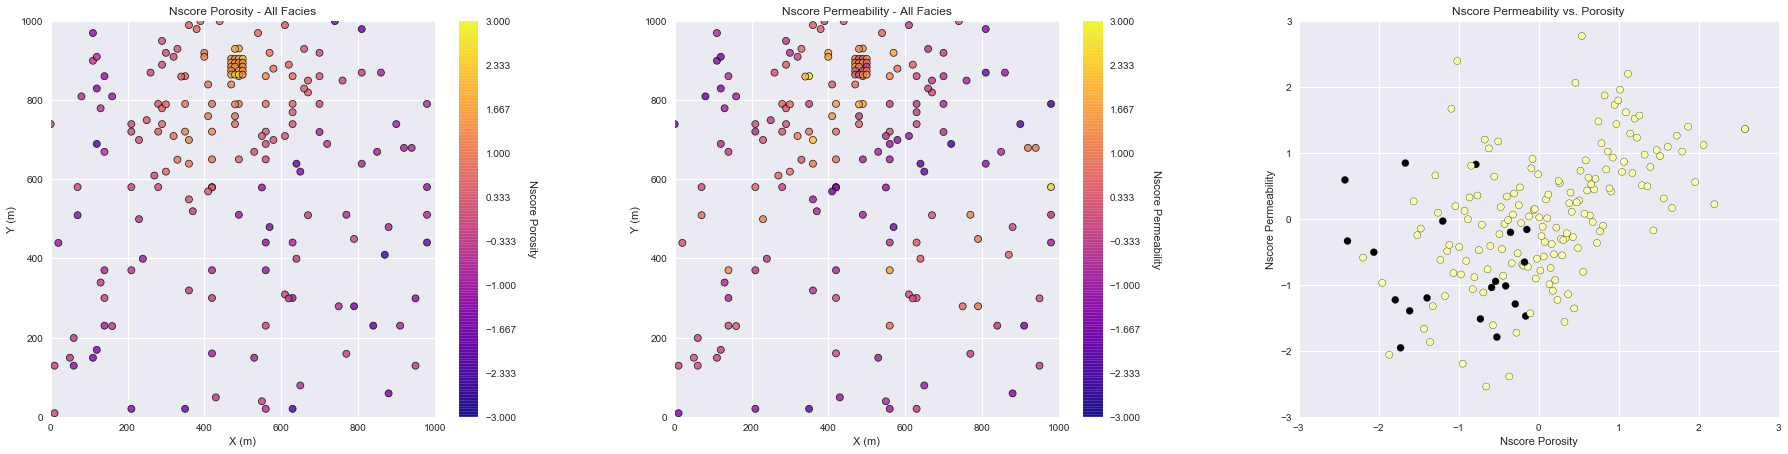

In [19]:
cmap = plt.cm.plasma                    # color map
plt.subplot(131)
GSLIB.locmap_st(df_subset,'X','Y','NPor',0,1000,0,1000,-3,3,'Nscore Porosity - All Facies','X (m)','Y (m)','Nscore Porosity',cmap)

plt.subplot(132)
GSLIB.locmap_st(df_subset,'X','Y','NPerm',0,1000,0,1000,-3,3,'Nscore Permeability - All Facies','X (m)','Y (m)','Nscore Permeability',cmap)

plt.subplot(133)
facies = df_subset['Facies'].values +0.01
plt.scatter(df_subset['NPor'],df_subset['NPerm'],c = facies,edgecolor = 'black',cmap = plt.cm.inferno)
#plt.plot([-3,3],[-3,3],color = 'black')
plt.xlabel(r'Nscore Porosity')
plt.ylabel(r'Nscore Permeability')
plt.title('Nscore Permeability vs. Porosity')
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3, top=1, wspace=0.3, hspace=0.3)
plt.show()

# 1. Calculation IK


In [34]:
## Set Basic parameters
nxdis = 1; nydis = 1                       # block kriging discretizations, 1 for point kriging
ndmin = 0; ndmax = 10                      # minimum and maximum data for kriging 
radius = 100                               # maximum search distance
ktype = 1                                  # kriging type, 0 - simple, 1 - ordinary
ivtype = 0                                 # variable type, 0 - categorical, 1 - continuous
tmin = -999; tmax = 999;                   # data trimming limits

xmin = 0.0; xmax = 1000.0               # range of x values
ymin = 0.0; ymax = 1000.0               # range of y values

xsiz = 10; ysiz = 10                    # cell size
nx = 100; ny = 100                      # number of cells
xmn = 5; ymn = 5                        # grid origin, location center of lower left cell

In [22]:
## Define Categories and Variogram model
ncut = 2                                   # number of facies
thresh = [0,1]                             # the facies categories
gcdf = [0.4,0.6]                           # the global proportions of the categories
varios = []                                # the variogram list
varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=0.2,azi1=45,hmaj1=500,hmin1=200,it2=1,cc2=0.8,azi2=45,hmaj2=9999,hmin2=700)) # shale indicator variogram
varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=0.2,azi1=45,hmaj1=500,hmin1=200,it2=1,cc2=0.8,azi2=45,hmaj2=9999,hmin2=700)) # sand indicator variogram

Data for IK3D: Variable column Facies
  Number   = 178
Setting up rotation matrices for variogram and search
Working on the kriging
   currently on estimate 0
   currently on estimate 1000
   currently on estimate 2000
   currently on estimate 3000
   currently on estimate 4000
   currently on estimate 5000
   currently on estimate 6000
   currently on estimate 7000
   currently on estimate 8000
   currently on estimate 9000


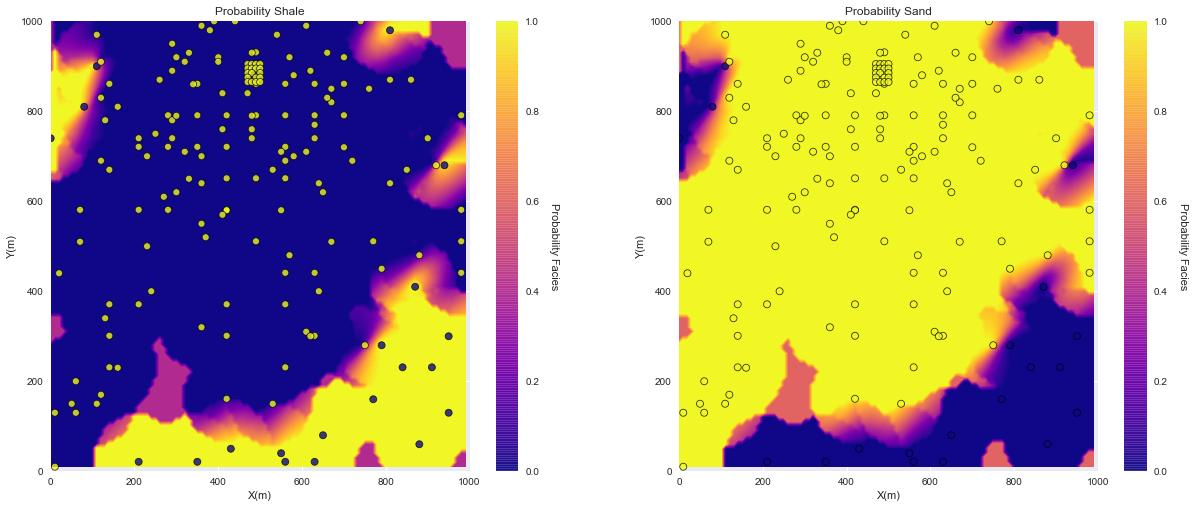

In [71]:
from indicator_Kriging import ordrel, ksol_numpy, cova2, setup_rotmat, ik2d

no_trend = np.zeros((1,1))                  # null ndarray not of correct size so ik2d will not use a trend - will fix this
ikmap = geostats.ik2d(df_subset,'X','Y','Facies',ivtype,0,2,thresh,gcdf,no_trend,tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz, ndmin,ndmax,radius,ktype,vario=varios)

plt.subplot(221) 
GSLIB.locpix_st(ikmap[:,:,0],xmin,xmax,ymin,ymax,xsiz,0.0,1.0,df,'X','Y','Facies','Probability Shale','X(m)','Y(m)','Probability Facies',cmap)
plt.subplot(222) 
GSLIB.locpix_st(ikmap[:,:,1],xmin,xmax,ymin,ymax,xsiz,0.0,1.0,df,'X','Y','Facies','Probability Sand','X(m)','Y(m)','Probability Facies',cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2) 
plt.show()